In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
df = pd.read_csv("GOOG.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,49.813286,51.835709,47.800831,49.982655,49.982655,44871300
1,2004-08-20,50.316402,54.336334,50.062355,53.952770,53.952770,22942800
2,2004-08-23,55.168217,56.528118,54.321388,54.495735,54.495735,18342800
3,2004-08-24,55.412300,55.591629,51.591621,52.239193,52.239193,15319700
4,2004-08-25,52.284027,53.798351,51.746044,52.802086,52.802086,9232100


In [3]:
# Step 2: Preprocessing the data
# We only need the 'Close' column for prediction
data = df[['Date', 'Close']].copy()

# Convert 'Date' column to datetime type and set as index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [4]:
# Scale the data using MinMaxScaler (feature scaling)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

In [5]:
# Step 3: Create data sequences for training
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

In [6]:
# Create function to generate sequences
def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(x), np.array(y)

In [7]:
# Set the sequence length (e.g., using 60 days of data to predict the next day's price)
seq_length = 60
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

In [9]:
# Reshape data for LSTM input (samples, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [11]:
# Step 4: Build the Recurrent Neural Network (RNN)
model = Sequential()

# LSTM Layer (Recurrent)
model.add(LSTM(units=100, return_sequences=False, input_shape=(X_train.shape[1], 1)))
# Dense Layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [12]:
# Step 5: Train the model
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop], verbose=1)

Epoch 1/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0168 - val_loss: 0.0016
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 1.3091e-04 - val_loss: 8.6544e-04
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 1.1644e-04 - val_loss: 5.9762e-04
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 1.0377e-04 - val_loss: 5.9564e-04
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: 1.1996e-04 - val_loss: 5.5628e-04
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 1.0394e-04 - val_loss: 5.3455e-04
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 9.4839e-05 - val_loss: 5.6691e-04
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 9.3252e-05 - val_loss: 5.4483e-04
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 9.0566e-05 - val_loss: 5.2132e-04
Epoch 10/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 9.4421e-05 - val_loss: 4.9573e-04
Epoch 11/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 8.8331e-05 - val_

In [13]:
# Step 6: Make predictions
predictions = model.predict(X_test)

# Inverse scaling to get actual prices
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test)

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


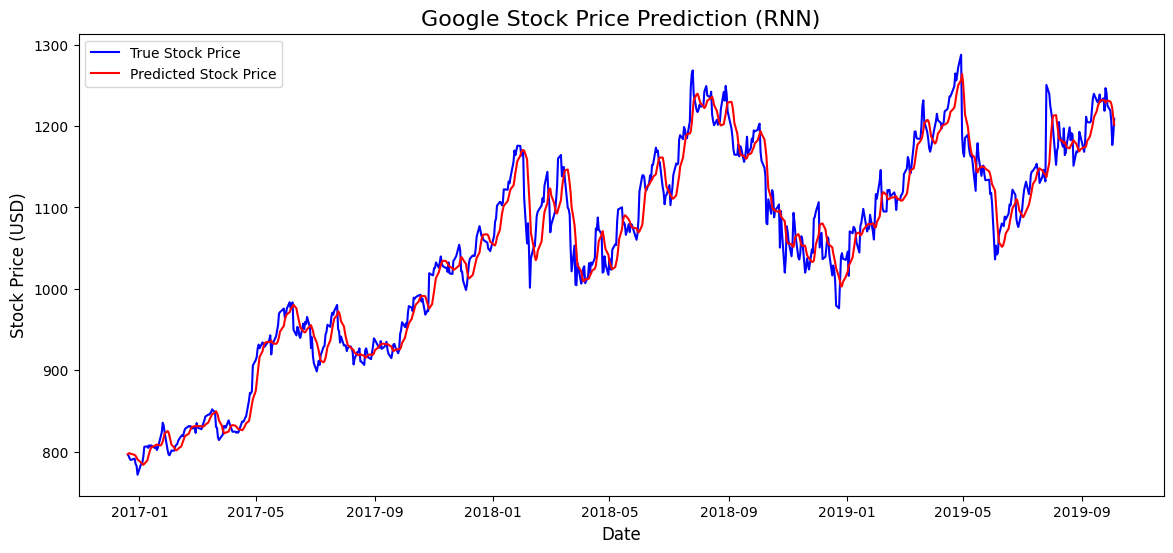

In [14]:
# Step 7: Visualize the results
plt.figure(figsize=(14, 6))
plt.plot(data.index[-len(y_test_actual):], y_test_actual, label="True Stock Price", color='blue')
plt.plot(data.index[-len(predictions):], predictions, label="Predicted Stock Price", color='red')
plt.title("Google Stock Price Prediction (RNN)", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Stock Price (USD)", fontsize=12)
plt.legend()
plt.show()

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

mse = mean_squared_error(y_test_actual, predictions)
mae = mean_absolute_error(y_test_actual, predictions)
r2 = r2_score(y_test_actual, predictions)

print(f"📉 MSE: {mse:.2f}")
print(f"📉 MAE: {mae:.2f}")
print(f"📈 R2 Score: {r2:.4f}")


📉 MSE: 584.16
📉 MAE: 18.23
📈 R2 Score: 0.9628


In [17]:
sequence_length = 60 
future_days = 5
last_sequence = scaled_data[-sequence_length:]  # shape: (60, 1)

future_preds = []
current_seq = last_sequence

for _ in range(future_days):
    pred = model.predict(current_seq.reshape(1, sequence_length, 1))
    future_preds.append(pred[0, 0])
    
    # Append pred & slide window
    current_seq = np.append(current_seq, pred)[-sequence_length:]

# Inverse scale
future_preds = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1)).flatten()

print("🔮 Future Predictions:", future_preds)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
🔮 Future Predictions: [1197.4304 1194.008  1191.5432 1189.6461 1188.1035]
